# Data Prep

For our end csv file we want the headers:

<code>id | StudyInstanceUID | human_label | integer_label | Negative for Pneumonia Typical Appearance | Indeterminate Appearance | Atypical Appearance | opacity_count | x | y | width | height | file_path | image_width | image_height | image_shape</code>

This should give us the appropiate information to use Faster RCNN.

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image
import cv2
import ast
from tqdm import tqdm
import glob
import os
import pydicom

In [2]:
# import csv
train_study = pd.read_csv('../input/train_study_level.csv')
# import csv
train_image = pd.read_csv('../input/train_image_level.csv')

In [3]:
train_study.head(1)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0


In [4]:
train_image.head(1)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75


## Extract ID and Merge

We want to merge the two datasets on StudyInstanceUID, this will be our starting dataset...

In [5]:
# split and extract id
train_study['id'] = train_study['id'].str.split('_').apply(lambda x: x[0])
# rename for merging
train_study = train_study.rename({'id':'StudyInstanceUID'}, axis=1)
# merge datasets
train = pd.merge(train_image, train_study, on='StudyInstanceUID')
# split id column
train['id'] = train['id'].str.split('_').apply(lambda x: x[0])

In [6]:
train.head(1)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0


## Opacity Count

The opacity count, is the number of classes in an image. So within the label comment, it will give information regarding the bounding box. We wish to count the number of boxes within a picture.

In [7]:
train['opacity_count'] = train['label'].str.count('opacity')

In [8]:
train.head(1)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2


Just to prove that the opacity count, counts the number of boxes here is a comparision...

In [9]:
print(train.loc[0, ['id', 'boxes', 'opacity_count']].values)
print(train.loc[50, ['id', 'boxes', 'opacity_count']].values)
print(train.loc[100, ['id', 'boxes', 'opacity_count']].values)

['000a312787f2'
 "[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]"
 2]
['0171f8209991'
 "[{'x': 65.20329, 'y': 180.37412, 'width': 533.12551, 'height': 637.97346}, {'x': 643.64447, 'y': 238.12938, 'width': 424.72339, 'height': 443.38271}]"
 2]
['036fe057963a'
 "[{'x': 488.78241, 'y': 957.77525, 'width': 329.96524, 'height': 572.32904}]"
 1]


As you can see the number of boxes within the boxes list is equal to the opacity_count...

## Labels for Humans and Machines

We wish to create two new columns, one for a human to read what the row label is and a number indicating the label.

Mapping:

<code>{0: 'Negative for Pneumonia',
1: 'Typical Appearance',
2: 'Indeterminate Appearance',
3: 'Atypical Appearance'}</code>

### Integer Label

In [10]:
labels = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

Negative for Pneumonia      1736
Typical Appearance          3007
Indeterminate Appearance    1108
Atypical Appearance          483
dtype: int64

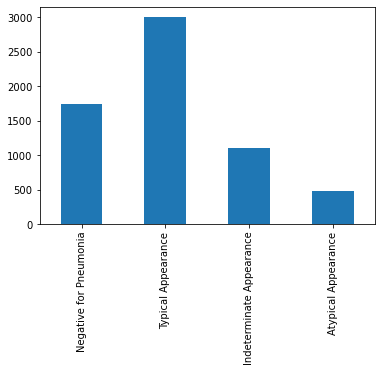

In [11]:
train[labels].sum().plot(kind = 'bar')
train[labels].sum()

In [12]:
train['integer_label'] = [element.index(1) for element in train[labels].values.tolist()]

In [13]:
train.head(5)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count,integer_label
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,3
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1


### Human Label

applying integer_label to mapping...

In [14]:
mapping = {0: 'Negative for Pneumonia',
1: 'Typical Appearance',
2: 'Indeterminate Appearance',
3: 'Atypical Appearance'}

In [15]:
train['human_label'] = train.integer_label.apply(lambda x: mapping[x])

In [16]:
train.head(5)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count,integer_label,human_label
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,Typical Appearance
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,Negative for Pneumonia
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,Typical Appearance
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,3,Atypical Appearance
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,Typical Appearance


## Image Dimensions

Now comes the lengthy bit, we want to find the image dimensions for each image and insert into our dataframe. This will be useful for feature engineering and also resizing the bounding boxes.

### Generate File Paths

In [17]:
# train directory
TRAIN_DIR = "C:\\Users\\Admin\\Git\\SIIM\\train\\"
# paths
paths = list()
# create path column
for _id in tqdm(train['StudyInstanceUID']):
    try:
        paths.append(glob.glob(os.path.join(TRAIN_DIR, _id +"/*/*"))[0])
    except:
        paths.append('')
train['file_path'] = paths
train.head(5)

100%|██████████████████████████████████████████████████████████| 6334/6334 [00:00<00:00, 6906.00it/s]


,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count,integer_label,human_label,file_path
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\5776db0cec75\814...
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,Negative for Pneumonia,C:\Users\Admin\Git\SIIM\train\ff0879eb20ed\d8a...
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\9d514ce429a7\228...
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,3,Atypical Appearance,C:\Users\Admin\Git\SIIM\train\28dddc8559b2\4d4...
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\dfd9fdd85a3e\491...


### Test Case

For our test case, we will load the image using dcm, then grab its relevant data information.

In [18]:
test_id = '000a312787f2'
test_file_path= train.loc[0, 'file_path']
test_dcm = pydicom.dcmread(test_file_path)

### Header Data

In [19]:
def myprint(dataset, indent=0):
    """Go through all items in the dataset and print them with custom format

    Modelled after Dataset._pretty_str()
    """
    dont_print = ['Pixel Data', 'File Meta Information Version']

    indent_string = "   " * indent
    next_indent_string = "   " * (indent + 1)

    for data_element in dataset:
        if data_element.VR == "SQ":   # a sequence
            print(indent_string, data_element.name)
            for sequence_item in data_element.value:
                myprint(sequence_item, indent + 1)
                print(next_indent_string + "---------")
        else:
            if data_element.name in dont_print:
                print("""<item not printed -- in the "don't print" list>""")
            else:
                repr_value = repr(data_element.value)
                if len(repr_value) > 50:
                    repr_value = repr_value[:50] + "..."
                print("{0:s} {1:s} = {2:s}".format(indent_string,
                                                   data_element.name,
                                                   repr_value))

myprint(test_dcm)

 Specific Character Set = 'ISO_IR 100'
 Image Type = ['ORIGINAL', 'PRIMARY']
 SOP Class UID = '71228e4340de'
 SOP Instance UID = '000a312787f2'
 Study Date = '526316e376d4'
 Study Time = '8ccfb6acf07f'
 Accession Number = 'f6cd7f2019f5'
 Modality = 'DX'
 Patient's Name = 'd4268f26ed05'
 Patient ID = 'dcc3fdf6426a'
 Patient's Sex = 'M'
 De-identification Method = 'CTP Default:  based on DICOM PS3.15 AnnexE. Detai...
 De-identification Method Code Sequence
    Code Value = '113100'
    Coding Scheme Designator = 'DCM'
    Code Meaning = 'Basic Application Confidentiality Profile'
   ---------
    Code Value = '113105'
    Coding Scheme Designator = 'DCM'
    Code Meaning = 'Clean Descriptors Option'
   ---------
    Code Value = '113107'
    Coding Scheme Designator = 'DCM'
    Code Meaning = 'Retain Longitudinal Temporal Information Modified...
   ---------
    Code Value = '113108'
    Coding Scheme Designator = 'DCM'
    Code Meaning = 'Retain Patient Characteristics Option'
   ------

There is a lot of useful information here that I won't touch on, for example; sex, Photometric Interpretation, Modalit, Imager Pixel Spacing, Samples per Pixel...

But for now if we grab the Rows and Columns of the Image.

Just to prove rows and columns do indeed equal the image height and width

In [20]:
print('Pixel array shape: {}'.format(test_dcm.pixel_array.shape))
print('Number of rows and columns: {}'.format((test_dcm.Rows, test_dcm.Columns)))

Pixel array shape: (3488, 4256)
Number of rows and columns: (3488, 4256)


In [21]:
# grab image dimensions
height_list = list()
width_list = list()
shape_list = list()
for file_path in tqdm(train['StudyInstanceUID']):
    try:
        dcm = pydicom.dcmread(test_file_path)
        height_list.append(dcm.Rows)
        width_list.append(dcm.Columns)
        shape_list.append(dcm.pixel_array.shape)
    except:
        height_list.append(None)
        width_list.append(None)
        shape_list.append(None)
train['image_width'] = width_list
train['image_height'] = height_list
train['image_shape'] = shape_list
train.head(5)

100%|████████████████████████████████████████████████████████████| 6334/6334 [02:05<00:00, 50.52it/s]


,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count,integer_label,human_label,file_path,image_width,image_height,image_shape
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\5776db0cec75\814...,4256,3488,"(3488, 4256)"
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,Negative for Pneumonia,C:\Users\Admin\Git\SIIM\train\ff0879eb20ed\d8a...,4256,3488,"(3488, 4256)"
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\9d514ce429a7\228...,4256,3488,"(3488, 4256)"
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,3,Atypical Appearance,C:\Users\Admin\Git\SIIM\train\28dddc8559b2\4d4...,4256,3488,"(3488, 4256)"
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\dfd9fdd85a3e\491...,4256,3488,"(3488, 4256)"


## Bouding Boxes

The boxes column currently is a string, so first we are going to apply ast to the string, to retrieve list. Then we can explode the boxes column, so we have one box per row.

In [22]:
def apply_ast(string):
    try:
        return(ast.literal_eval(string))
    except:
        return(None)

In [23]:
train['boxes'] = train.boxes.apply(apply_ast)

In [24]:
train.head(5)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count,integer_label,human_label,file_path,image_width,image_height,image_shape
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\5776db0cec75\814...,4256,3488,"(3488, 4256)"
1,000c3a3f293f,None,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,Negative for Pneumonia,C:\Users\Admin\Git\SIIM\train\ff0879eb20ed\d8a...,4256,3488,"(3488, 4256)"
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\9d514ce429a7\228...,4256,3488,"(3488, 4256)"
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,3,Atypical Appearance,C:\Users\Admin\Git\SIIM\train\28dddc8559b2\4d4...,4256,3488,"(3488, 4256)"
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\dfd9fdd85a3e\491...,4256,3488,"(3488, 4256)"


## Data Exploration and Feature Engineering

We need to deal with Null types, duplicates and background classes...

In [25]:
# check for Null values
train.isna().sum()

id                             0
boxes                       2040
label                          0
StudyInstanceUID               0
Negative for Pneumonia         0
Typical Appearance             0
Indeterminate Appearance       0
Atypical Appearance            0
opacity_count                  0
integer_label                  0
human_label                    0
file_path                      0
image_width                    0
image_height                   0
image_shape                    0
dtype: int64

In [26]:
train[train.id.duplicated()]

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count,integer_label,human_label,file_path,image_width,image_height,image_shape


## Height and Width

I assumed there would be different values for images, but it appears not...

In [27]:
print(train.image_width.value_counts())
print(train.image_height.value_counts())

4256    6334
Name: image_width, dtype: int64
3488    6334
Name: image_height, dtype: int64


## How to deal with Negative for Pneumonia

An empty box should not be filled.

# Balancing Classes

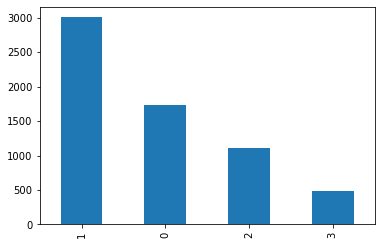

In [28]:
train.integer_label.value_counts().plot(kind='bar')
plt.show()

## Stratified id_s

Becuase we are sending the dataset, unique id_s. In order to balance the classes properly we must k fold on the original dataset not the exploded one.

In [29]:
strat = train.copy()

In [30]:
strat = strat[strat.file_path!=''].reset_index(drop=True)

In [31]:
# stratified by integer_label
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

In [32]:
for n, (train_index, val_index) in enumerate(skf.split(X=strat.index, y=strat.integer_label)):
    strat.loc[strat.iloc[val_index].index, 'fold'] = int(n)
strat['fold'] = strat['fold'].astype(int)

In [33]:
print(strat.groupby(['fold', strat.integer_label]).size())

fold  integer_label
0     0                333
      1                580
      2                212
      3                 94
1     0                334
      1                579
      2                212
      3                 94
2     0                334
      1                579
      2                212
      3                 93
3     0                334
      1                579
      2                212
      3                 93
4     0                334
      1                579
      2                212
      3                 93
dtype: int64


In [34]:
val_fold = 4
train_ids = strat[strat.fold!=4].id.values
val_ids = strat[strat.fold==4].id.values

In [35]:
len(train_ids)

4874

In [36]:
len(val_ids)

1218

In [37]:
strat.isnull().sum()

id                             0
boxes                       1973
label                          0
StudyInstanceUID               0
Negative for Pneumonia         0
Typical Appearance             0
Indeterminate Appearance       0
Atypical Appearance            0
opacity_count                  0
integer_label                  0
human_label                    0
file_path                      0
image_width                    0
image_height                   0
image_shape                    0
fold                           0
dtype: int64

In [38]:
strat.to_csv('../input/id_s.csv', index=False)

In [39]:
strat[strat.file_path=='']

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count,integer_label,human_label,file_path,image_width,image_height,image_shape,fold
